In [1]:
import yfinance as yf
import pandas as pd


In [2]:
sp500 = yf.Ticker("^GSPC")
sp500 = sp500.history(period="max")
sp500 = sp500.loc['2000-01-01':].copy()

In [3]:
del sp500['Dividends']
del sp500['Stock Splits']

In [4]:
sp500['Tomorrow'] = sp500['Close'].shift(-1)
sp500['Target'] = (sp500['Tomorrow'] > sp500['Close']).astype(int)

In [5]:
sp500.to_csv('sp500_hist.csv')

In [6]:
from sklearn.ensemble import RandomForestClassifier

#n_estimators = number of trees in the forest
#min_samples_split = minimum number of samples required to split an internal node
#min_samples_leaf = minimum number of samples required to be at a leaf node
#random_state = seed used by the random number generator

model = RandomForestClassifier(n_estimators=200, min_samples_split=100, min_samples_leaf=5, random_state=1)

#train = taking all the rows except the last 100
#test = taking the last 100 rows
train = sp500.iloc[:-100]
test = sp500.iloc[-100:]

prediction_features = ['Open', 'High', 'Low', 'Close', 'Volume']

#fitting the model
model.fit(train[prediction_features], train['Target'])

RandomForestClassifier(min_samples_leaf=5, min_samples_split=100,
                       n_estimators=200, random_state=1)

In [7]:
from sklearn.metrics import precision_score

#predicting the target
predictions = model.predict(test[prediction_features])
predictions = pd.Series(predictions, index=test.index)
precision_score(test['Target'], predictions)

0.75

In [8]:
def predict(train, test, prediction_features, model):
    model.fit(train[prediction_features], train['Target'])
    predictions = model.predict(test[prediction_features])
    predictions = pd.Series(predictions, index=test.index, name='Predictions')
    combined = pd.concat([test['Target'], predictions], axis=1)
    return combined

In [9]:
def backtest(data, model, prediction_features, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predicts = predict(train, test, prediction_features, model)
        all_predictions.append(predicts)
    
    return pd.concat(all_predictions)

In [10]:
predicts = backtest(sp500, model, prediction_features)
precision_score(predicts['Target'], predicts['Predictions'])

0.5222758990874933

In [11]:
horizons = [2,5,60,250,1000]
new_prediction_features = []

for horizon in horizons:
    rolling_averages = sp500.rolling(horizon).mean()

    ratio_column = f"Close_Ratio_{horizon}"
    sp500[ratio_column] = sp500["Close"] / rolling_averages["Close"]

    trend_column = f"Trend_{horizon}"
    sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()["Target"]

    new_prediction_features += [ratio_column, trend_column]

In [12]:
sp500 = sp500.dropna(subset=sp500.columns[sp500.columns != "Tomorrow"]) # Drop rows with NaN values

In [13]:
model = RandomForestClassifier(n_estimators=500, min_samples_split=10, min_samples_leaf=5, random_state=1)


In [14]:
def predict(train, test, prediction_features, model):
    model.fit(train[prediction_features], train['Target'])
    predictions = model.predict_proba(test[prediction_features])[:,1]
    predictions[predictions >= 0.6] = 1
    predictions[predictions < 0.6] = 0
    predictions = pd.Series(predictions, index=test.index, name="Predictions")
    combined = pd.concat([test['Target'], predictions], axis=1)
    return combined

In [15]:
predicts = backtest(sp500, model, new_prediction_features)
precision_score(predicts['Target'], predicts['Predictions'])

0.5563258232235702

In [16]:
predicts.to_csv('sp500_predicts.csv')

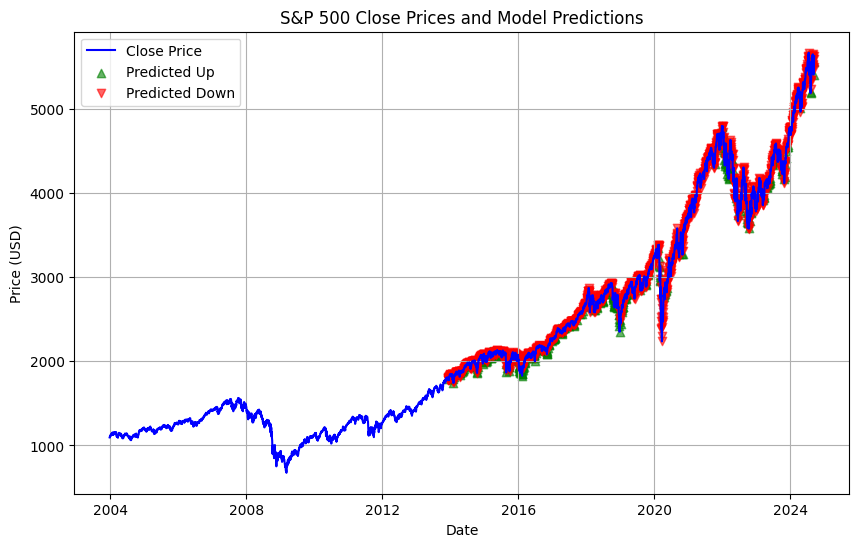

In [17]:
import matplotlib.pyplot as plt

# plots the actual closing prices
plt.figure(figsize=(10, 6))
plt.plot(sp500.index, sp500["Close"], label="Close Price", color="blue")

# highlight predictions
# green for predicted upward movement and red for downward
pred_up = predicts[predicts["Predictions"] == 1].index
pred_down = predicts[predicts["Predictions"] == 0].index

# points where the model predicted upward trend
plt.scatter(pred_up, sp500.loc[pred_up]["Close"], label="Predicted Up", color="green", marker='^', alpha=0.6)

# points where the model predicted downward trend
plt.scatter(pred_down, sp500.loc[pred_down]["Close"], label="Predicted Down", color="red", marker='v', alpha=0.6)

# labels and title
plt.title("S&P 500 Close Prices and Model Predictions")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()
